In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.simplefilter("ignore")

# np.random.seed(1)
# random.seed(1)

import sys
sys.path.append("..")
sys.path.append("../shared")

from wednesdaySPEED import simulation

import numba
print(numba.__version__)

import itertools
import operator
import scipy as sc
from analytic_tools import *
import statsmodels.api as sm
import stochastic

0.53.1


In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def visualiseNICE(G, P, N, S, X, D, T, U, C):
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(
        ncols=1, nrows=8, figsize=(12,12), sharex=True, gridspec_kw = 
        {'wspace':0, 'hspace':0.05, 'height_ratios':[2,2,1,1,1,1,1,1]}
    )
    im1 = ax1.imshow(G.T, cmap="bone", interpolation="None", aspect="auto")
    im4 = ax4.imshow(P.T, cmap="hot", interpolation="None", aspect="auto")
    amnwc = np.max(np.abs(N-initial_account_balance))  # absolute max net worth change
    vmin, vmax = initial_account_balance-amnwc, initial_account_balance+amnwc
    im5 = ax5.imshow(N.T, cmap="bwr", interpolation="None", aspect="auto", vmin=vmin, vmax=vmax)

    size = "15%"

    cax1 = make_axes_locatable(ax1).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    cax4 = make_axes_locatable(ax4).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im4, cax=cax4, orientation='vertical')
    cax5 = make_axes_locatable(ax5).append_axes('right', size=size, pad=0.05)
    fig.colorbar(im5, cax=cax5, orientation='vertical')

    cax2 = make_axes_locatable(ax2).append_axes('right', size=size, pad=0.05)
    cax2.hist(S, orientation="horizontal", bins=np.linspace(np.min(S), np.max(S), len(S)//2))
    # cax2.hist(np.log10(S), orientation="horizontal", bins=np.logspace(np.log10(np.min(S)), np.log10(np.max(S)), len(S)//2))
    # cax2.set_xscale("log")
    # cax2.set_yscale("log")
    cax2.get_xaxis().set_visible(False)
    cax2.get_yaxis().set_visible(False)

    cax3 = make_axes_locatable(ax3).append_axes('right', size=size, pad=0.05)
    cax3.hist(X, orientation="horizontal", bins=np.linspace(np.min(X), np.max(X), len(X)//5))
    cax3.get_xaxis().set_visible(False)
    cax3.get_yaxis().set_visible(False)

    cax6 = make_axes_locatable(ax6).append_axes('right', size=size, pad=0.05)
    cax6.get_xaxis().set_visible(False)
    cax6.get_yaxis().set_visible(False)
    cax7 = make_axes_locatable(ax7).append_axes('right', size=size, pad=0.05)
    cax7.get_xaxis().set_visible(False)
    cax7.get_yaxis().set_visible(False)
    cax8 = make_axes_locatable(ax8).append_axes('right', size=size, pad=0.05)
    cax8.get_xaxis().set_visible(False)
    cax8.get_yaxis().set_visible(False)

    # for ax in (ax2,ax3):
    #     cax = make_axes_locatable(ax).append_axes('right', size=size, pad=0.05)
    #     # cax.axis('off')

    ##ax2.set_yscale("log")
    ax2.plot(S, label="S")
    Ws = [25]
    for W in Ws:
        ax2.plot(np.arange(W-1, len(S)), moving_average(S, W), label=f"MA{W}")
    ax2.grid(alpha=0.4)
    # ax2.legend(ncol=len(Ws)+1)

    ax3.bar(np.arange(len(X)), X)
    ax3.grid(alpha=0.4)

    # if D.shape[1] < 25:
    ax6.plot(np.mean(D[0],axis=1), color="C0", alpha=1, label="CA")
    ax6.plot(np.mean(D[1],axis=1), color="C1", alpha=1, label="momentum")
    ax6.plot(np.mean(D[2],axis=1), color="C2", alpha=1, label="invert")
    ax6.plot(np.max(D[0],axis=1), ":", color="C0", alpha=1, label="CA")
    ax6.plot(np.max(D[1],axis=1), ":", color="C1", alpha=1, label="momentum")
    ax6.plot(np.max(D[2],axis=1), ":", color="C2", alpha=1, label="invert")
    ax6.plot(np.min(D[0],axis=1), "--", color="C0", alpha=1, label="CA")
    ax6.plot(np.min(D[1],axis=1), "--", color="C1", alpha=1, label="momentum")
    ax6.plot(np.min(D[2],axis=1), "--", color="C2", alpha=1, label="invert")
    # ax6.plot(np.mean(D,axis=1), color="black", alpha=1)
    ax6.grid(alpha=0.4)
    # ax6.legend()


    ax7.set_yscale("symlog")
    ax7.plot(T, label="stack")
    ax7.plot(U, label="called shares")
    ax7.grid(alpha=0.4)
    ax7.legend()

    # if D.shape[1] < 25:
    #     ax6.plot(D, color="black", alpha=0.3)
    # ax6.plot(np.mean(D,axis=1), color="black", alpha=1)
    ax8.imshow(C.T, cmap="binary", interpolation="None", aspect="auto")
    # ax6.grid(alpha=0.4)
    
    ax8.set_xlabel("time")
    # ax2.set_ylabel("standardised log returns")
    ax2.set_ylabel("close price")
    ax1.set_ylabel("agents")
    ax3.set_ylabel("log return")
    ax4.set_ylabel("portfolio")
    ax5.set_ylabel("net worth")
    ax6.set_ylabel("influence (I)")
    ax7.set_ylabel("stack")
    ax8.set_ylabel("margin calls")

    # fig.colorbar(im, cax=ax4)
    
    plt.tight_layout()
    # plt.savefig("tmp.png", dpi=300)
    plt.show()

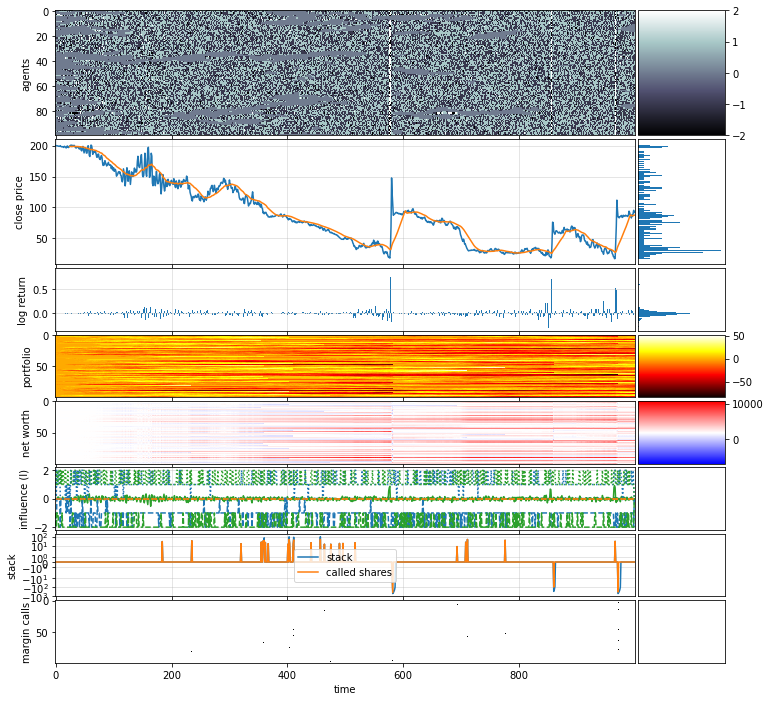

In [28]:
G,P,N,S,X,D,T,U,C, initial_account_balance = simulation(trigger = False, bound = True, pd = 0.05, pe = 0.01,
                    ph = 0.0485, pa = 0.3, N0 = 1000, N1 = 100, A = 1.8, a=2*1.8, h=1, 
                    pi1 = 0.1, pi2 = 0, pi3 = 0.9)
visualiseNICE(G, P, N, S, X, D, T, U, C)

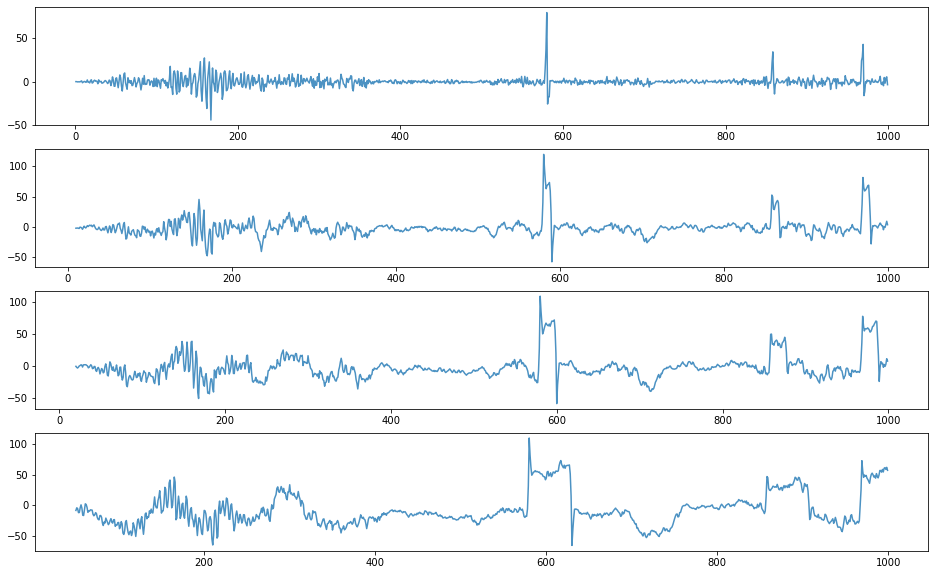

In [29]:
fig, axs = plt.subplots(4,1,figsize=[16,10])
axs = axs.ravel()


T_vals = [1,10,20,50]
t = np.arange(len(S))

for index,T in enumerate(T_vals):
    fluc = []
    for i in range(len(S)-T):
        fluc.append(S[i+T] - S[i])

    axs[index].plot(t[T:len(S)], fluc, alpha = 0.8)

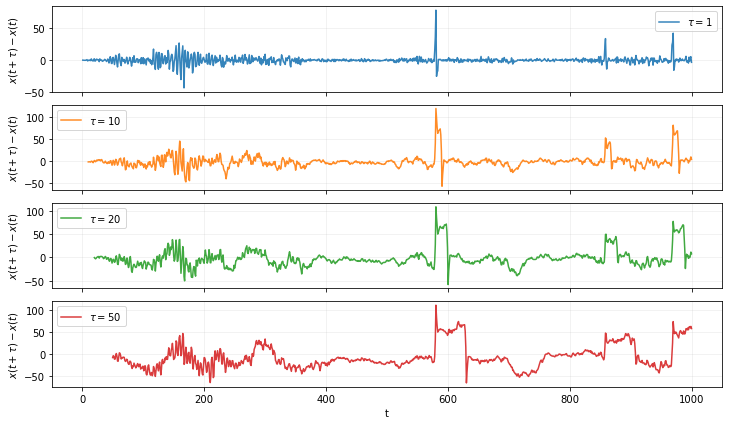

In [83]:
fig, axs = plt.subplots(
        ncols=1, nrows=4, figsize=(12,7), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0.15})
        
axs = axs.ravel()

colours = ["C0", "C1", "C2", "C3"]

T_vals = [1,10,20,50]
t = np.arange(len(S))

for index,T in enumerate(T_vals):
    fluc = []
    for i in range(len(S)-T):
        fluc.append(S[i+T] - S[i])

    axs[index].plot(t[T:len(S)], fluc, alpha = 0.9, color=colours[index], label=r"$\tau = {{{}}}$".format(T_vals[index]))
    axs[index].grid(alpha=0.2)
    axs[index].set_ylabel(r"$x(t + \tau) - x(t)$")
    axs[index].legend()

fig.align_ylabels()
plt.xlabel(r"t")
plt.savefig("x_t_tau_2", dpi=300)
##plt.xlim(200, 500)
plt.show()


### Multifractal analysis

In [80]:
def fractal_latent_heat_alex(series, tau, N):
    splt = np.array_split(series, N)
    q_vals = np.linspace(-5, 5, 100)

    ## structs
    C_q = np.zeros(q_vals.shape[0] - 2) # Second derivative
    X_q = np.zeros(q_vals.shape[0])
    S_q = np.zeros(q_vals.shape[0] - 1) # First derivative
    mu_i = np.zeros(len(splt))
    denom_sum = 0

    ## eq 10
    for i in range(len(splt)):
        denom_sum += np.abs(splt[i][tau] - splt[i][0])

    for j in range(len(splt)):
        mu_i[j] = np.abs(splt[j][tau] - splt[j][0]) / denom_sum
        
    print(np.sum(mu_i))
        
    lhs = np.zeros((q_vals.shape[0]))
    rhs = np.zeros((q_vals.shape[0]))

    for k, val in enumerate(q_vals):
        ## eq 11
        lhs[k] = np.log(np.sum(mu_i**val))
        rhs[k] = np.log(N)
        ## solve for slope of log-log
        ## x_q equivelent to tau(q) in casenna
        X_q[k] = lhs[k] / rhs[k] # read: Chi_q

    # ## cannot obtain C_q for first and last q vals
    for l in range(1, q_vals.shape[0] - 1):
        C_q[l - 1] = X_q[l + 1] - 2 * X_q[l] + X_q[l - 1]
        S_q[l - 1] = X_q[l + 1] - X_q[l - 1]

    return q_vals, C_q, S_q, X_q

In [81]:
mu_i = 0.0002508764081315876
val = -5
np.sum(mu_i**val)

1.0062383942489353e+18

1.0000000000000002


(-5.0, 5.0)

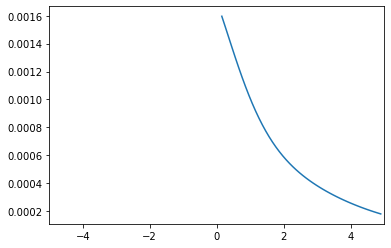

In [82]:
tau = 1
q_vals, C_q, S_q, X_q = fractal_latent_heat_alex(np.array(S), tau, 10)
plt.plot(q_vals[1:len(q_vals)-1], C_q)
plt.xlim([-5,5])